<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/Xgboost_ensemble_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
First 5 rows of the dataset:
  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  

Dataset shape: (7660, 7)

Missing values:
Billing Date     0
Net Weight       0
Sales Region     0
Invoice Value    0
Material Code    0
Size             0
QTY(EA)          0
dtype: int64

Summary Statistics:
                        Billing Date   Net Weight  Invoice Value      QT

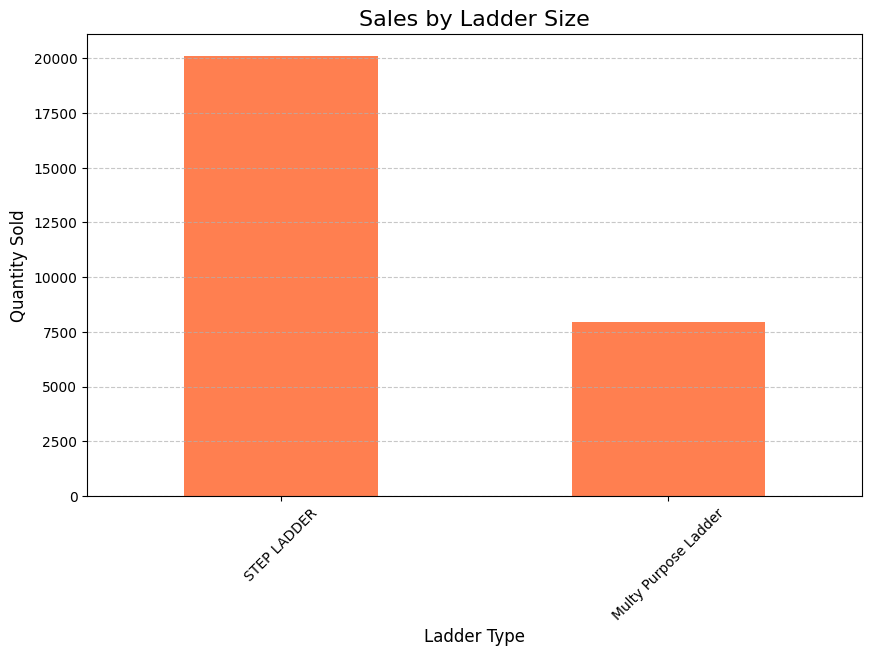


After filtering invalid entries, shape: (7249, 5)

Total regional Sales:
Sales Region
Direct             18008
Key Accounts        3118
Kandy               2582
East                1166
Kurunagela          1066
North               1065
Negombo              762
Southern             677
Colombo              638
Projects             206
Projects Export        4
Exports                1
Name: QTY(EA), dtype: int64


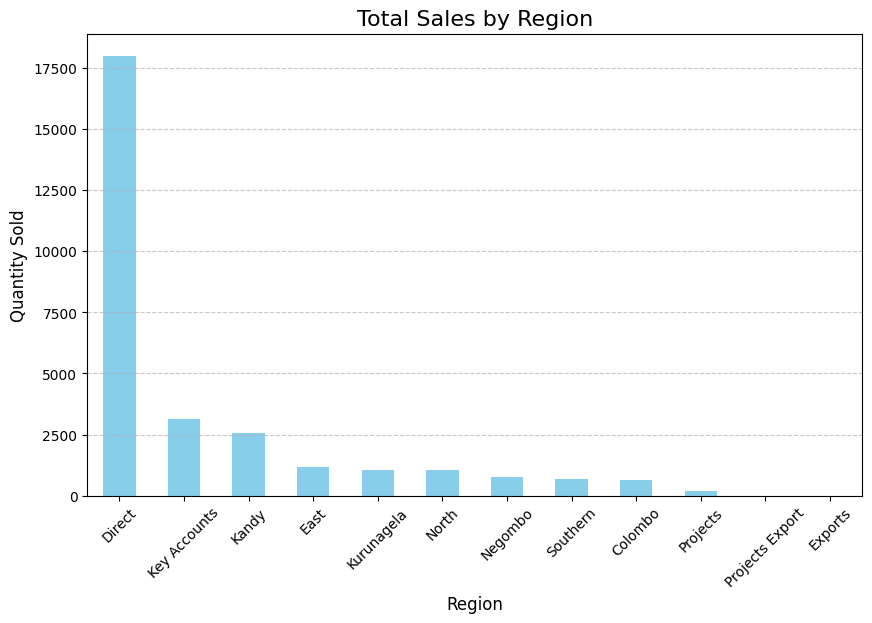


Analyzing outliers in QTY(EA)...
Column QTY(EA) statistics:
- Mean: 4.04
- Median: 1.00
- Std Dev: 10.02
- Min: 1.00
- Max: 173.00
- IQR: 2.00
- Number of outliers: 822 (11.34%)


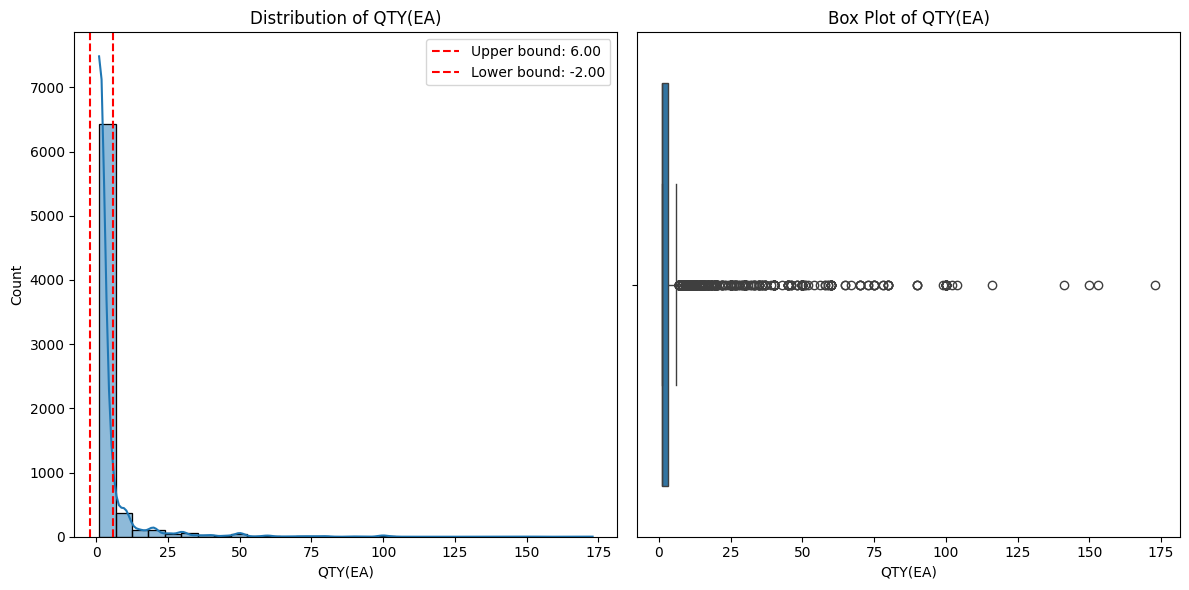


Handling outliers in QTY(EA) using winsorize method...
Winsorized values below 1.00 and above 17.00

Encoding categorical features...

Engineering advanced features...

Preparing data for training...
Using time-based split: train size = 5799, test size = 1450

Creating ensemble model...

📊 Ensemble Model - Train Set:
✅ MAE: 1.0505 | ✅ RMSE: 2.0645 | ✅ R² Score: 0.7436
📊 Ensemble Model - Test Set:
✅ MAE: 1.2975 | ✅ RMSE: 2.4265 | ✅ R² Score: 0.6644


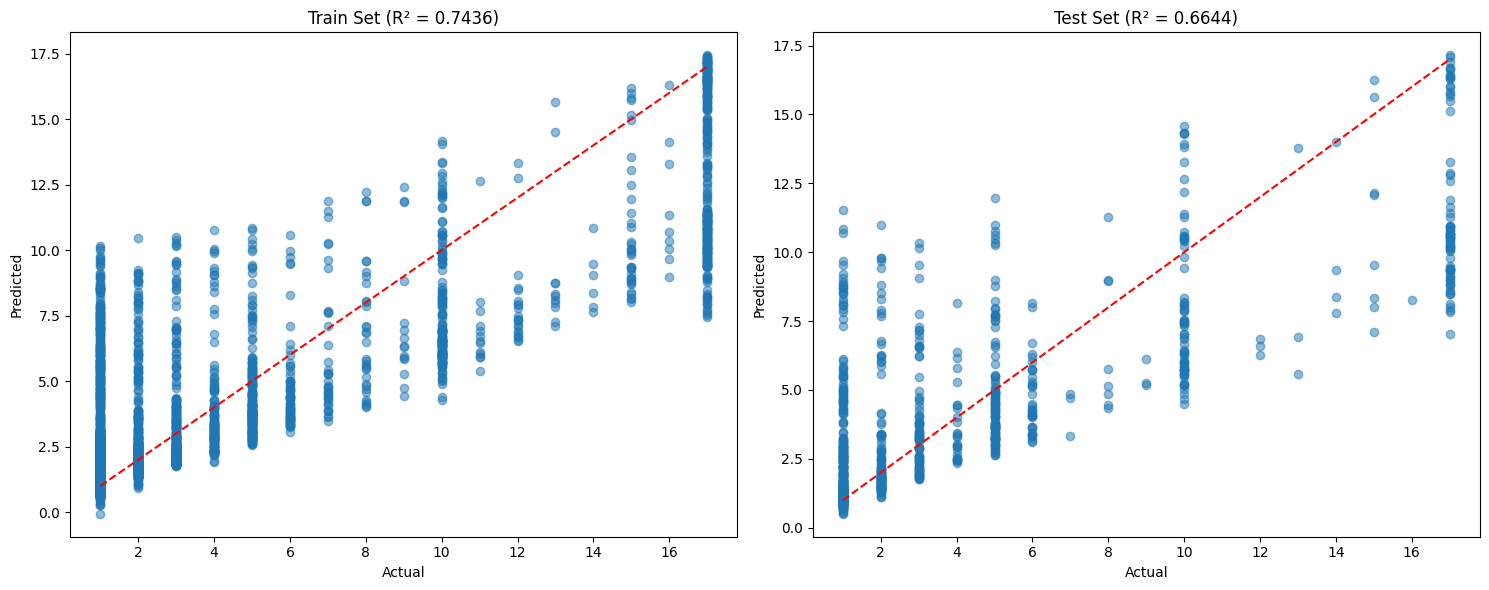


Model saved to ladder_sales_ensemble_pipeline.joblib

Model training completed successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy.stats import uniform, randint
import joblib
import shap
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_and_preprocess_data(file_path):
    print("Loading data...")
    data = pd.ExcelFile(file_path)
    df = data.parse('Data')

    print("First 5 rows of the dataset:")
    print(df.head())

    print(f"\nDataset shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())

    print("\nSummary Statistics:")
    print(df.describe())

    categorical_cols = ['Sales Region', 'Material Code', 'Size', 'QTY(EA)']
    for col in categorical_cols:
        print(f"\nUnique values in {col}:")
        print(df[col].unique())

    size_sales = df.groupby('Size')['QTY(EA)'].sum().sort_values(ascending=False)
    print("\nTotal Monthly Sale:")
    print(size_sales)

    plt.figure(figsize=(10, 6))
    size_sales.plot(kind='bar', color='coral')
    plt.title('Sales by Ladder Size', fontsize=16)
    plt.xlabel('Ladder Type', fontsize=12)
    plt.ylabel('Quantity Sold', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    df = df.drop(columns=["Net Weight", "Invoice Value"])
    df = df[df['QTY(EA)'] > 0]
    print(f"\nAfter filtering invalid entries, shape: {df.shape}")

    df['Date'] = df['Billing Date']
    df['Year'] = df['Billing Date'].dt.year
    df['Month'] = df['Billing Date'].dt.month
    df['Day'] = df['Billing Date'].dt.day
    df['Weekday'] = df['Billing Date'].dt.weekday
    df['Quarter'] = df['Billing Date'].dt.quarter
    df['DayOfYear'] = df['Billing Date'].dt.dayofyear
    df['WeekOfYear'] = df['Billing Date'].dt.isocalendar().week
    df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['IsMonthStart'] = df['Billing Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Billing Date'].dt.is_month_end.astype(int)
    df['IsQuarterStart'] = df['Billing Date'].dt.is_quarter_start.astype(int)
    df['IsQuarterEnd'] = df['Billing Date'].dt.is_quarter_end.astype(int)

    df = df.drop(columns=["Billing Date"])

    region_mapping = {
        "R1": "North", "R2": "Kandy", "R3": "Kurunagela", "R4": "Southern", "R5": "Negombo",
        "R6": "East", "R7": "Colombo", "R8": "Key Accounts", "PR": "Projects", "PR-EX": "Projects Export",
        "EX": "Exports", "DR": "Direct"
    }
    df["Sales Region"] = df["Sales Region"].replace(region_mapping)

    region_sales = df.groupby('Sales Region')['QTY(EA)'].sum().sort_values(ascending=False)
    print("\nTotal regional Sales:")
    print(region_sales)

    plt.figure(figsize=(10, 6))
    region_sales.plot(kind='bar', color='skyblue')
    plt.title('Total Sales by Region', fontsize=16)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel('Quantity Sold', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nAnalyzing outliers in QTY(EA)...")
    analyze_outliers(df, 'QTY(EA)')
    df = handle_outliers(df, 'QTY(EA)')

    return df

def analyze_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Column {column} statistics:")
    print(f"- Mean: {df[column].mean():.2f}")
    print(f"- Median: {df[column].median():.2f}")
    print(f"- Std Dev: {df[column].std():.2f}")
    print(f"- Min: {df[column].min():.2f}")
    print(f"- Max: {df[column].max():.2f}")
    print(f"- IQR: {IQR:.2f}")
    print(f"- Number of outliers: {outliers.shape[0]} ({outliers.shape[0]/df.shape[0]*100:.2f}%)")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
    plt.axvline(x=upper_bound, color='r', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
    plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f"Box Plot of {column}")

    plt.tight_layout()
    plt.show()

    return outliers

def handle_outliers(df, column, method='winsorize'):
    print(f"\nHandling outliers in {column} using {method} method...")
    if method == 'winsorize':
        lower_limit = df[column].quantile(0.05)
        upper_limit = df[column].quantile(0.95)
        df_clean = df.copy()
        df_clean[column] = df_clean[column].clip(lower=lower_limit, upper=upper_limit)
        print(f"Winsorized values below {lower_limit:.2f} and above {upper_limit:.2f}")
    else:
        df_clean = df.copy()
        print("No outlier treatment applied")
    return df_clean

def encode_categorical_features(df):
    print("\nEncoding categorical features...")
    material_freq = df['Material Code'].value_counts(normalize=True).to_dict()
    df['Material_Code_Freq'] = df['Material Code'].map(material_freq)
    df_encoded = pd.get_dummies(df, columns=["Sales Region", "Size"], drop_first=False)
    df_encoded = df_encoded.drop(columns=["Material Code"])
    return df_encoded

def engineer_features(df):
    print("\nEngineering advanced features...")
    df = df.sort_values(by='Date')

    df['QTY(EA)_lag1'] = df['QTY(EA)'].shift(1)
    df['QTY(EA)_lag7'] = df['QTY(EA)'].shift(7)
    df['QTY(EA)_lag14'] = df['QTY(EA)'].shift(14)
    df['QTY(EA)_lag30'] = df['QTY(EA)'].shift(30)

    windows = [3, 7, 14, 30]
    for window in windows:
        df[f'QTY(EA)rolling_mean{window}'] = df['QTY(EA)'].rolling(window=window).mean()
        df[f'QTY(EA)rolling_std{window}'] = df['QTY(EA)'].rolling(window=window).std()
        df[f'QTY(EA)rolling_sum{window}'] = df['QTY(EA)'].rolling(window=window).sum()

    df['QTY(EA)_expanding_mean'] = df['QTY(EA)'].expanding().mean()
    df['QTY(EA)_expanding_std'] = df['QTY(EA)'].expanding().std()

    df['season'] = df['Month'].apply(lambda x: 1 if x in [12, 1, 2] else
                                     2 if x in [3, 4, 5] else
                                     3 if x in [6, 7, 8] else 4)
    df['weekday_season'] = df['Weekday'] * df['season']
    df['month_size_interaction'] = df['Month'] * df.filter(like='Size_').sum(axis=1)

    df = df.fillna(method='ffill').fillna(method='bfill')
    for col in df.columns:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median() if df[col].dtype.kind in 'iufc' else df[col].mode()[0])

    return df

def prepare_data_for_training(df, target='QTY(EA)', test_size=0.2, time_based=True):
    print("\nPreparing data for training...")
    X = df.drop(columns=[target, 'Date'])
    y = df[target]

    if time_based:
        train_size = int((1 - test_size) * len(df))
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
        print(f"Using time-based split: train size = {len(X_train)}, test size = {len(X_test)}")
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        print(f"Using random split: train size = {len(X_train)}, test size = {len(X_test)}")

    return X_train, X_test, y_train, y_test

def create_ensemble_model(X_train, y_train, X_test, y_test):
    print("\nCreating ensemble model...")
    xgb_1 = xgb.XGBRegressor(
        n_estimators=100, max_depth=4, learning_rate=0.05, subsample=0.8,
        colsample_bytree=0.8, reg_alpha=0.5, reg_lambda=1.0, random_state=42
    )
    xgb_2 = xgb.XGBRegressor(
        n_estimators=150, max_depth=5, learning_rate=0.03, subsample=0.7,
        colsample_bytree=0.7, reg_alpha=0.3, reg_lambda=0.8, random_state=24
    )
    ridge = Ridge(alpha=1.0, random_state=42)
    elastic = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)

    voting_model = VotingRegressor(
        estimators=[('xgb1', xgb_1), ('xgb2', xgb_2), ('ridge', ridge), ('elastic', elastic)]
    )
    voting_model.fit(X_train, y_train)

    evaluate_model(voting_model, X_train, y_train, X_test, y_test, "Ensemble Model")
    return voting_model

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = {
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'R²': r2_score(y_train, y_train_pred)
    }
    test_metrics = {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R²': r2_score(y_test, y_test_pred)
    }

    print(f"\n📊 {model_name} - Train Set:")
    print(f"✅ MAE: {train_metrics['MAE']:.4f} | ✅ RMSE: {train_metrics['RMSE']:.4f} | ✅ R² Score: {train_metrics['R²']:.4f}")
    print(f"📊 {model_name} - Test Set:")
    print(f"✅ MAE: {test_metrics['MAE']:.4f} | ✅ RMSE: {test_metrics['RMSE']:.4f} | ✅ R² Score: {test_metrics['R²']:.4f}")

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Train Set (R² = {train_metrics["R²"]:.4f})')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Test Set (R² = {test_metrics["R²"]:.4f})')
    plt.tight_layout()
    plt.show()

def save_model(model, filename="ladder_sales_ensemble_pipeline.joblib"):
    joblib.dump(model, filename)
    print(f"\nModel saved to {filename}")

def main():
    file_path = "Ladders updated data.xlsx"
    df = load_and_preprocess_data(file_path)
    df_encoded = encode_categorical_features(df)
    df_engineered = engineer_features(df_encoded)
    X_train, X_test, y_train, y_test = prepare_data_for_training(df_engineered, time_based=True)
    ensemble_model = create_ensemble_model(X_train, y_train, X_test, y_test)
    save_model(ensemble_model, "ladder_sales_ensemble_pipeline.joblib")
    print("\nModel training completed successfully!")

if __name__ == "__main__":
    main()